<a href="https://colab.research.google.com/github/AbhijyotAhire/M516R-GH1019994/blob/main/GH1019994_M516R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***AI in Sustainability: Harnessing Superconductors for Renewable Energy Innovation***


Solaris City Sustainability Project
This project models a scalable, renewable energy infrastructure to support Aurora City’s goal of achieving a 100% renewable energy supply by 2040.
The study evaluates room-temperature superconductors and Superconducting Magnetic Energy Storage (SMES) technology for improved energy storage and transmission efficiency.


The primary objective of this notebook is to identify the plausibility of creating a solar battery that, when combined with a solar panel installation or any other renewable energy source, can sustain the energy consumption of an ideal American city. In order to do this, the data analysis algorithms will be employed for prediction and optimization


This study uses two key datasets to assess the feasibility of integrating SMES with solar power in Solaris City.

1.   PJM Hourly Energy Consumption Data - PJM Interconnection LLC (PJM) is a regional transmission organization (RTO) in the United States. It is part of the Eastern Interconnection grid operating an electric transmission system serving all or parts of Delaware, Illinois, Indiana, Kentucky, Maryland, Michigan, New Jersey, North Carolina, Ohio, Pennsylvania, Tennessee, Virginia, West Virginia, and the District of Columbia. The hourly power consumption data comes from PJM's website and are in megawatts (MW). The regions have changed over the years so data may only appear for certain dates per region. The dataset can be found [here](https://dataminer2.pjm.com/feed/hourly_solar_power_forecast/definition).

2.   Solar Energy Production
Hourly output at each of The City of Calgary's solar photovoltaic projects - The hourly output at each of the city of Calgary's solar photovoltaic projects and the locations of City of Calgary solar photovoltaic installations. The dataset can be found [here](https://data.calgary.ca/Environment/Solar-Photovoltaic-Sites/csgq-e555/about_data).



Both of these datasets can be downloaded and stored in the personal Google Drive for the use of this case study.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


We use this command to mount Google Drive to Google Colab environment to access datasets from the drive.

In [3]:
!pip install prophet
!pip install cplex
!pip install stable_baselines3
!pip install pulp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 MB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.3/182.3 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.7/17.7 MB 79.9 MB/s eta 0:00:00


These commands are used to install specific Python libraries that your code depends on. Since Google Colab provides a fresh environment each time you start a session, you need to install these libraries before you can use them in your code.

Here is a breakdown for each command:

!pip install prophet:

Prophet is a library developed by Meta for time series forecasting.
Your code likely uses Prophet to make predictions about future energy consumption or production.

!pip install cplex:

CPLEX is a powerful optimization solver developed by IBM.
Since the code involves optimization problems (e.g., finding the optimal battery capacity), CPLEX might be used to solve them efficiently.

!pip install stable_baselines3:

Stable Baselines3 is a library for reinforcement learning algorithms.
This library is used for training an agent to make decisions about energy management.

!pip install pulp:

PuLP is a Python library for linear programming.
It is used to formulate and solve optimization problems related to resource allocation or scheduling, which is relevant to the energy management scenario.


In [4]:
import numpy as np
import pandas as pd
import random
from datetime import datetime, timedelta
import math
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from prophet import Prophet
from scipy.optimize import minimize
import pulp
import matplotlib.pyplot as plt
import statistics
import sys
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
import gymnasium as gym
from gymnasium import spaces

These import statements bring in external libraries and modules to provide your code with additional functionality. Essentially, they are like gathering tools for a specific task – you need the right tools to get the job done efficiently.

Breakdown:

Data manipulation and numerical computation:

import numpy as np: NumPy is fundamental for numerical computations in Python. It provides powerful array objects and tools for working with them.

import pandas as pd: Pandas is used for data manipulation and analysis. It offers DataFrames, which are excellent for organizing and working with tabular data.

import random: This module provides functions for generating random numbers, which can be useful for simulations or data generation.

from datetime import datetime, timedelta: These are used for working with dates and times, which is crucial for analyzing time-series data like energy consumption.

import math: This module provides standard mathematical functions.

import statistics: Provides functions for calculating basic statistical properties like mean, median, etc.
Machine Learning and Forecasting:

import tensorflow as tf: TensorFlow is a popular deep learning library. It's used for building and training neural networks.
from tensorflow.keras.models

import Sequential: Imports the Sequential model, a way to build neural networks layer by layer.

from tensorflow.keras.layers import LSTM, Dense: Imports specific layers for building an LSTM (Long Short-Term Memory) neural network, often used for time-series data.

from prophet import Prophet: Prophet is a time-series forecasting library developed by Meta. It's used for making predictions about future trends.

Optimization:

from scipy.optimize import minimize: This function from SciPy is used for finding the minimum of a function, which is essential for optimization tasks.

import pulp: PuLP is a linear programming library used for solving optimization problems, potentially used for optimizing energy distribution strategies.

Visualization and Reinforcement Learning:

import matplotlib.pyplot as plt: Matplotlib is the go-to library for creating visualizations in Python, like plots and charts.

from stable_baselines3 import PPO: Imports the Proximal Policy Optimization (PPO) algorithm from Stable Baselines3, a reinforcement learning library.

import gymnasium as gym: Gymnasium provides environments for developing and testing reinforcement learning agents.

from gymnasium import spaces: Imports the spaces module for defining the action and observation spaces of a reinforcement learning environment.

system-specific parameters and functions

import sys: Provides access to system-specific parameters and functions, such as exiting from the application using sys.exit().
By importing these libraries, your code has the tools it needs to perform complex data analysis, forecasting, optimization, and more. I hope this detailed explanation helps! Let me know if you have any other questions.

In [5]:
def get_readings_for_date(csv_file_path, target_date,time_column,energy_column):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(csv_file_path)
    df[time_column] = pd.to_datetime(df[time_column])
    df['filter_date'] = df[time_column].dt.date
    filtered_df = df[df['filter_date'] == target_date]

    return filtered_df[[time_column,energy_column]]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


The get_readings_for_date function takes a CSV file, a target date, and column names as input. It then reads the data, converts the time column to datetime objects, filters the data to select rows matching the target date, and returns the relevant time and energy readings for that date. This function is crucial for isolating and analyzing data for specific dates within a larger dataset.



This function is designed to extract specific energy readings from a CSV file for a given target date. It's like searching a database for records that match a particular date and then retrieving the desired information from those records. This is a common task when working with time-series data, where you often need to analyze data for specific time periods.

In [6]:
def generate_random_date(delim):

    start_date = datetime.strptime('2015-9-1', '%Y-%m-%d')
    end_date = datetime.strptime('2018-8-2', '%Y-%m-%d')

    days_difference = (end_date - start_date).days
    random_days = random.randint(0, days_difference)

    random_date = (start_date + timedelta(days=random_days)).date()
    return f"{random_date.year}{delim}{random_date.month}{delim}{random_date.day}"
target_date = pd.to_datetime(generate_random_date("/"))
month = target_date.month
target_date

Timestamp('2016-05-20 00:00:00')

This function is used to generate a random date within a specified range (from September 1, 2015, to August 2, 2018, in this case). This random date is then used to select a specific day's worth of data for analysis or simulation. Introducing randomness can be useful in scenarios where you want to test your code or model with different data points, making it more robust and less sensitive to specific dates.

The code generates a random date, stores it as a Timestamp object in target_date, extracts the month, and then uses this target_date for further processing in the notebook. This helps introduce variability in data selection and analysis. I hope this helps clarify! Let me know if you have any other questions.

# **Data Cleaning & Analysis**


 Our objective here is  to orchestrate the reduction of the city's conventional power plants while simultaneously bolstering the deployment of solar panels and SMES solar batteries.

The first step on their journey is to gather 2-3 years worth of energy consumption data from the city's power grid and energy production data from an existing solar field that will be undergoing a substantial expansion in the coming months.

In [7]:
csv_file_path = '/content/drive/MyDrive/Solar_Energy_Production.csv' # Solar energy production data sourced from solar installations in Calgary, Alberta
def get_production(date):
    production_readings_for_date = get_readings_for_date(csv_file_path, date.date(),'date','kWh').groupby('date')['kWh'].sum().reset_index()
    production_readings_for_date["kWh"] = production_readings_for_date["kWh"]*1000 # To account for a major scale-up in functionality
    return production_readings_for_date
production_readings_for_date = get_production(target_date)

This code snippet defines a function to retrieve and scale solar energy production data for a given date, then uses this function to get the data for the target date. This data is then stored in a DataFrame, ready for use in further analysis and modeling. The scaling factor accounts for potential expansions in the solar installation. I hope this explanation is helpful! Feel free to ask any more questions.

This code defines a function get_production that retrieves and scales solar energy production data for a specific date. It then uses this function to get the production data for the target_date (which was randomly generated earlier). This step is essential for preparing the solar energy production data that will be used later in the analysis and modeling.

Steps:

csv_file_path = ...: This line defines the path to the CSV file containing solar energy production data. The comment indicates that the data is sourced from solar installations in Calgary, Alberta.

def get_production(date):: This defines the function get_production, which takes a date as input.

production_readings_for_date = ...: This line calls the get_readings_for_date function (defined earlier) to extract energy readings from the CSV file for the given date. The groupby('date')['kWh'].sum() part calculates the total energy production for each date by summing the 'kWh' values for all rows with the same date. .reset_index() converts the grouped data back into a regular DataFrame.

production_readings_for_date["kWh"] = ...: This line scales up the energy production values by a factor of 1000. The comment suggests this is done to account for a "major scale-up in functionality," possibly reflecting a planned expansion of the solar installation.

return production_readings_for_date: The function returns the DataFrame containing the scaled energy production data for the given date.

production_readings_for_date = get_production(target_date): This line calls the get_production function with the target_date as input and stores the returned DataFrame in the production_readings_for_date variable. This effectively loads and prepares the solar energy production data for the specific date being analyzed.

In [8]:
consumption_csv_file_path = '/content/drive/MyDrive/AEP_hourly.csv'
# Electrical energy comsumption data from American Electric Power Company, Inc (AEP) which is among the nation's largest generators of electricity, owning nearly 38,000 megawatts of generating capacity in the U.S and serving nearly 5 million customers.
def get_consumption(date):
    consumption_readings_for_date = get_readings_for_date(consumption_csv_file_path, date.date(),'Datetime','AEP_MW').sort_values(by='Datetime')
    consumption_readings_for_date["AEP_MW"]=consumption_readings_for_date["AEP_MW"]*200
    # converts MW to kW and also scales down the data by a factor of 5 to make more representative of the demands of a city the size of  Auroa City
    # Set the 'datetime' column as the index
    consumption_readings_for_date.set_index('Datetime', inplace=True)
    return consumption_readings_for_date
consumption_readings_for_date = get_consumption(target_date)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


This code snippet defines a function to retrieve, process, and scale electrical energy consumption data for a given date. It then uses this function to get the consumption data for the target date. The data is scaled down to represent the demands of Solaris City and stored in a DataFrame with 'Datetime' as the index. This prepares the consumption data for comparison with solar energy production and further analysis in the project. I hope this explanation is helpful! Feel free to ask if you have more questions.

This code defines a function get_consumption to retrieve and process electrical energy consumption data for a given date. It then uses this function to get the consumption data for the target_date. This step is crucial for preparing the energy consumption data, which will be compared with solar energy production and used for further analysis and modeling.

Steps:

consumption_csv_file_path = ...: This line defines the path to the CSV file containing electrical energy consumption data. The comment indicates that the data is from the American Electric Power Company (AEP).

def get_consumption(date):: This defines the function get_consumption, which takes a date as input.
consumption_readings_for_date = ...: This line calls the get_readings_for_date function to extract energy readings from the CSV file for the given date. It then sorts the data by the 'Datetime' column using sort_values(by='Datetime').

consumption_readings_for_date["AEP_MW"] = ...: This line scales the energy consumption values in the 'AEP_MW' column by a factor of 200. The comment explains that this is done to convert MW to kW and scale down the data to represent the demands of a city the size of Aurora City.

consumption_readings_for_date.set_index(...): This line sets the 'Datetime' column as the index of the DataFrame. This makes it easier to work with time-series data.
return consumption_readings_for_date: The function returns the DataFrame containing the processed energy consumption data for the given date.

consumption_readings_for_date = get_consumption(target_date): This line calls the get_consumption function with the target_date as input and stores the returned DataFrame in the consumption_readings_for_date variable. This prepares the energy consumption data for the target date, ready for use in further analysis.


In [9]:
production_readings_for_date.set_index("date", inplace=True)

# Adding in zeroes for the times not included with the assumption that those were times when the sun was not up
new_row = {"kWh":0}
for date in consumption_readings_for_date.index:
    if date not in production_readings_for_date.index:
        production_readings_for_date.loc[date] = new_row

production_readings_for_date = production_readings_for_date.sort_values(by='date')
production_readings_for_date

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,kWh
date,
2016-05-20 00:00:00,0.0
2016-05-20 01:00:00,0.0
2016-05-20 02:00:00,0.0
2016-05-20 03:00:00,0.0
2016-05-20 04:00:00,0.0
2016-05-20 05:00:00,0.0
2016-05-20 06:00:00,2.0
2016-05-20 07:00:00,5502.0
2016-05-20 08:00:00,15400.0


This code snippet modifies the production_readings_for_date DataFrame to ensure it is aligned with the consumption data by setting the index to 'date', adding missing data points (assuming zero production when the sun is not up), and sorting the data. This prepares the production data for comparison and further analysis in the project. The added data points ensure that there are energy production values for all hours of the day, even when the sun is down, making the analysis more comprehensive.

These steps ensure that the production data is aligned with the consumption data (which has hourly data) and ready for comparison and further processing.

In [10]:
energy_demand = ((consumption_readings_for_date['AEP_MW']-production_readings_for_date["kWh"]).mean())/1e6
total = (consumption_readings_for_date['AEP_MW'].mean())/1e6
f"Energy Demand Unfilled by Solar Installation on {target_date.date()}: {round(energy_demand,2)} GWh ({round(energy_demand/total,3)*100}% of demand)"

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'Energy Demand Unfilled by Solar Installation on 2016-05-20: 2.53 GWh (99.1% of demand)'

This code calculates the average energy demand that is not met by the solar installation on the target date, as well as the percentage of total demand that this represents. It then displays these values in a formatted string. This information is crucial for understanding the limitations of the existing solar installation and the need for additional energy resources or storage to meet the city's energy needs. I hope this explanation helps! Let me know if you have any other questions.

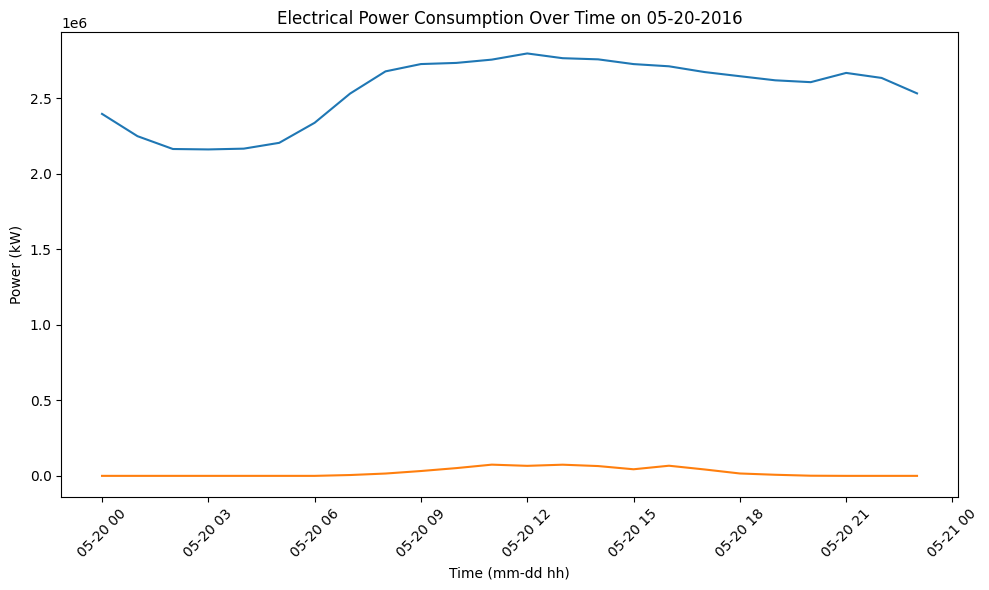

In [11]:
import matplotlib.pyplot as plt
# Plot datetime against energy consumption
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.plot(consumption_readings_for_date.index, consumption_readings_for_date['AEP_MW'], production_readings_for_date.index, production_readings_for_date["kWh"])
plt.xlabel('Time (mm-dd hh)')
plt.ylabel('Power (kW)')
plt.title(f'Electrical Power Consumption Over Time on {datetime.strftime (target_date,"%m-%d-%Y")}')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.tight_layout()
plt.show()

This code uses the matplotlib.pyplot library to create a line plot that visualizes the electrical power consumption and solar energy production over time for the target date. Visualizing this data helps to understand the patterns and relationship between energy consumption and production, providing insights into the effectiveness of the solar installation and potential areas for improvement.

The generated image is a line plot that shows the following:

X-axis: Represents the time of day (in hours) for the target date.

Y-axis: Represents the power in kilowatts (kW).

Two lines:
One line represents the total electrical power consumption of the city (from the consumption_readings_for_date data).

The other line represents the solar energy production (from the production_readings_for_date data).

Interpretation:

Comparison of consumption and production: By comparing the two lines, you can see how well the solar energy production meets the city's energy consumption throughout the day.

Peak demand and production: You can identify the times of day when energy consumption is highest and when solar energy production is at its peak.

Gaps in solar production: The plot highlights the times when solar energy production is low or zero (likely at night or during periods of low sunlight), indicating the need for alternative energy sources or storage.

# **Energy Forecasting & Optimization**



 With a more powerful battery to bridge the gap and the traditional power plants will still be able to pick up any remaining slack. To move to the next stage of the process which is working out how the solar installation and battery will handle the gradual buildup in electrical power demand that will result as the city phases out electricity from traditional power plants. We begin working on a machine learning model to take into account the season, time of day in hours, and battery's charge level to create a dynamic strategy to handle the load of the city's electricity demands.

# Navigating Neural Network Dilemmas in Energy Prediction

LSTM provides robust, long-term forecasting by capturing complex patterns in both daily and seasonal cycles, making it highly accurate for energy applications.

GRU offers a computationally efficient alternative for shorter, real-time forecasts, maintaining sequential dependencies with lower training times.

Prophet handles long-term seasonality and missing data, making it ideal for strategic forecasting over yearly cycles, while also providing interpretability for decision-makers.

Together, these models address Solaris City’s need for precise and adaptable energy forecasts, supporting the optimization of SMES capacity and ensuring reliable renewable energy supply.

We will go with Prophet since it is a forecasting tool that excels at predicting time-series data with multiple patterns and trends. Its ability to automatically detect seasonality and handle missing data makes it well-suited for predicting electricity distribution patterns.



In [12]:
df = pd.read_csv(consumption_csv_file_path)
df

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0
...,...,...
121268,2018-01-01 20:00:00,21089.0
121269,2018-01-01 21:00:00,20999.0
121270,2018-01-01 22:00:00,20820.0
121271,2018-01-01 23:00:00,20415.0


This code snippet is used to load the energy consumption data from the CSV file into a Pandas DataFrame called df. This is the initial step in preparing the consumption data for further analysis and modeling.

In [13]:
consumption_df = pd.DataFrame()
consumption_df["ds"]=df["Datetime"]
consumption_df["y"]=df["AEP_MW"]*200
consumption_df["y"].max()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


5139000.0

This code snippet creates a new Pandas DataFrame called consumption_df and prepares it for use with the Prophet forecasting library. It selects and renames specific columns from the original df DataFrame to match the format expected by Prophet.



Steps:

consumption_df = pd.DataFrame(): This line creates an empty Pandas DataFrame named consumption_df.

consumption_df["ds"] = df["Datetime"]: This line assigns the values from the 'Datetime' column of the original df DataFrame to a new column named 'ds' in the consumption_df DataFrame. Prophet expects the time series data to be in a column named 'ds'.

consumption_df["y"] = df["AEP_MW"] * 200: This line assigns the values from the 'AEP_MW' column of the original df DataFrame (multiplied by 200) to a new column named 'y' in the consumption_df DataFrame. Prophet expects the values to be forecasted to be in a column named 'y'. The multiplication by 200 is likely done to scale or transform the data as needed for the forecasting model. As mentioned earlier in the code this is likely done to convert MW to kW and scale down the data to represent the demands of a city the size of Solaris City.

consumption_df["y"].max(): This line calculates and displays the maximum value in the 'y' column of the consumption_df DataFrame. This is likely done to get a sense of the range of the data and potentially identify outliers or extreme values.

In [14]:
p_df = pd.read_csv(csv_file_path)
production_df = pd.DataFrame()
production_df["ds"] = p_df["date"]
production_df["y"]= p_df["kWh"]*1000
production_df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,ds,y
0,2017/09/11 08:00:00 AM,1130.0
1,2017/09/11 09:00:00 AM,2340.0
2,2017/09/11 10:00:00 AM,3656.0
3,2017/09/11 11:00:00 AM,4577.0
4,2017/09/11 12:00:00 PM,6506.0
...,...,...
258418,2023/03/12 03:00:00 PM,201285.0
258419,2023/03/12 04:00:00 PM,162582.0
258420,2023/03/12 05:00:00 PM,107060.0
258421,2023/03/12 06:00:00 PM,43074.0


This snippet focuses on preparing the solar energy production data for use with the Prophet forecasting library. It creates a new DataFrame, selects and renames columns, scales values, and displays the DataFrame for inspection.

Steps:

p_df = pd.read_csv(csv_file_path): This line reads the solar energy production data from the CSV file specified by csv_file_path into a Pandas DataFrame named p_df.

production_df = pd.DataFrame(): This line creates an empty Pandas DataFrame named production_df. This new DataFrame will be used to store the production data in the format expected by Prophet.

production_df["ds"] = p_df["date"]: This line assigns the values from the 'date' column of the p_df DataFrame to a new column named 'ds' in the production_df DataFrame. Prophet expects the time series data to be in a column named 'ds'.

production_df["y"] = p_df["kWh"] * 1000: This line assigns the values from the 'kWh' column of the p_df DataFrame (multiplied by 1000) to a new column named 'y' in the production_df DataFrame. Prophet expects the values to be forecasted to be in a column named 'y'. The multiplication by 1000 is likely done to scale or transform the data as needed for the forecasting model. As mentioned earlier in the code, this is done to account for a "major scale-up in functionality," possibly reflecting a planned expansion of the solar installation.

production_df: This line displays the contents of the production_df DataFrame. This allows you to quickly inspect the prepared data, see its structure, and get a sense of its values before it's used for forecasting.

In [15]:
c_model = Prophet()
c_model.fit(consumption_df)
future = c_model.make_future_dataframe(periods=131424, freq="H", include_history=False)
future

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
DEBUG:cmdstanpy:input tempfile: /tmp/tmp048tgf4p/6vsg5nox.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp048tgf4p/cin_njii.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85422', 'data', 'file=/tmp/tmp048tgf4p/6vsg5nox.json', 'init=/tmp/tmp048tgf4p/cin_njii.json', 'output', 'file=/tmp/tmp048tgf4p/prophet_modelcgd803od/prophet_model-20241104142820.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:28:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] s

,ds
0,2018-08-03 01:00:00
1,2018-08-03 02:00:00
2,2018-08-03 03:00:00
3,2018-08-03 04:00:00
4,2018-08-03 05:00:00
...,...
131419,2033-07-30 20:00:00
131420,2033-07-30 21:00:00
131421,2033-07-30 22:00:00
131422,2033-07-30 23:00:00


This code snippet initializes and trains a Prophet model for energy consumption forecasting, then creates a DataFrame with future dates for generating predictions. It specifies the number of future periods (131424 hours) and the frequency (hourly). The include_history=False parameter ensures that the future DataFrame contains only the future dates, not the historical data used for training. This sets up the timeframe for the energy consumption forecasts that will be generated in the subsequent parts of the code.

Steps:

c_model = Prophet(): This line creates an instance of the Prophet forecasting model and assigns it to the variable c_model.

c_model.fit(consumption_df): This line trains the Prophet model (c_model) using the data in the consumption_df DataFrame. This process involves fitting the model to the historical energy consumption data, allowing it to learn patterns and trends.

future = c_model.make_future_dataframe(...): This line creates a DataFrame called future that extends the dates from the historical data into the future.

periods=131424: Specifies the number of future periods to generate (in this case, 131424 hours). This corresponds to approximately 15 years into the future.

freq="H": Sets the frequency of the future dates to hourly ('H').
include_history=False: Indicates that the historical dates should not be included in the future DataFrame. This is because the focus is on generating forecasts for the future, not on re-predicting the past.

future: This line displays the contents of the future DataFrame, allowing you to inspect the generated future dates that will be used for forecasting.

In [16]:
p_model = Prophet()
p_model.fit(production_df)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
DEBUG:cmdstanpy:input tempfile: /tmp/tmp048tgf4p/9ho7vr2l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp048tgf4p/otuz27j0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28460', 'data', 'file=/tmp/tmp048tgf4p/9ho7vr2l.json', 'init=/tmp/tmp048tgf4p/otuz27j0.json', 'output', 'file=/tmp/tmp048tgf4p/prophet_modelt07yov48/prophet_model-20241104143112.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:31:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] s

This code initializes and trains a Prophet model (p_model) specifically for forecasting solar energy production. By training a separate model for production, the code aims to capture the unique characteristics and influencing factors of solar energy generation, leading to more accurate predictions. This is an important step in building a comprehensive energy forecasting system that considers both consumption and production aspects.

Steps:

p_model = Prophet(): This line creates a new instance of the Prophet forecasting model and assigns it to the variable p_model. This model will be used specifically for predicting solar energy production.

p_model.fit(production_df): This line trains the Prophet model (p_model) using the data in the production_df DataFrame. This process involves fitting the model to the historical solar energy production data, allowing it to learn patterns, seasonality, and trends specific to solar energy generation.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


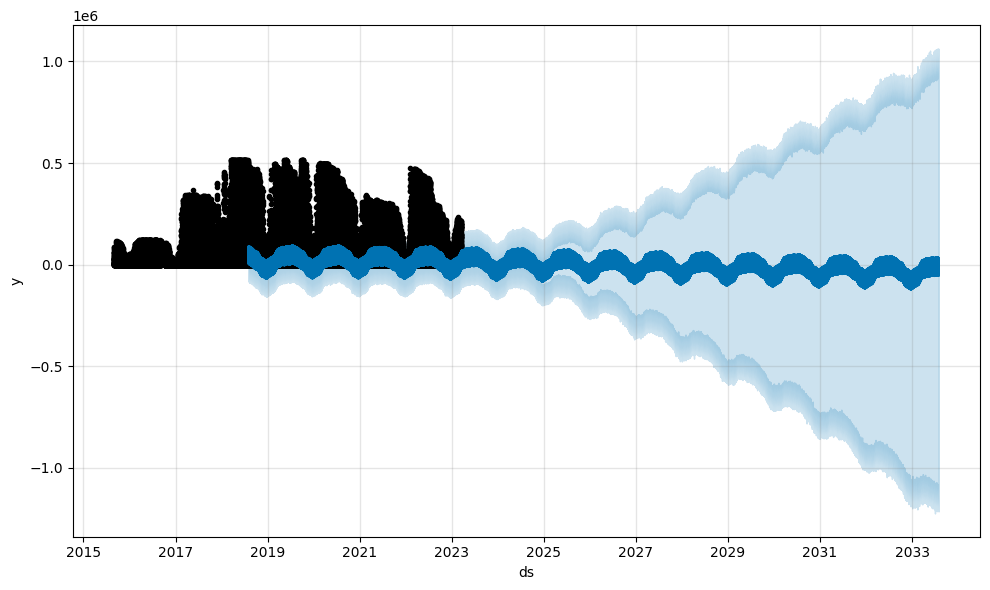

In [17]:
production_forecast=p_model.predict(future)
fig2 = p_model.plot(production_forecast)

The plot provides a visual representation of the predicted solar energy production over time, including both historical data and future forecasts. This allows you to understand the expected solar energy generation and the associated uncertainty, which is valuable for energy planning and resource management.

The figure generated by this code snippet is a line plot that shows the following:

X-axis: Represents the time, covering both the historical data used for training and the future dates for which forecasts were generated.

Y-axis: Represents the predicted solar energy production (in the units used in the production_df DataFrame, likely kWh or a scaled version).

Black dots: Represent the actual historical data points used for training the model.

Blue line: Represents the predicted values (forecasts) generated by the Prophet model.

Light blue shaded area: Represents the uncertainty interval (confidence interval) of the forecasts. This indicates the range within which the actual solar energy production is likely to fall.

Interpretation:

Production trends: The plot shows the overall trend of solar energy production, including any seasonality or cyclical patterns.

Future predictions: It visualizes the predicted solar energy production for the future timeframe defined in the future DataFrame.

Uncertainty: The shaded area indicates the level of uncertainty associated with the forecasts. Wider shaded areas suggest higher uncertainty.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


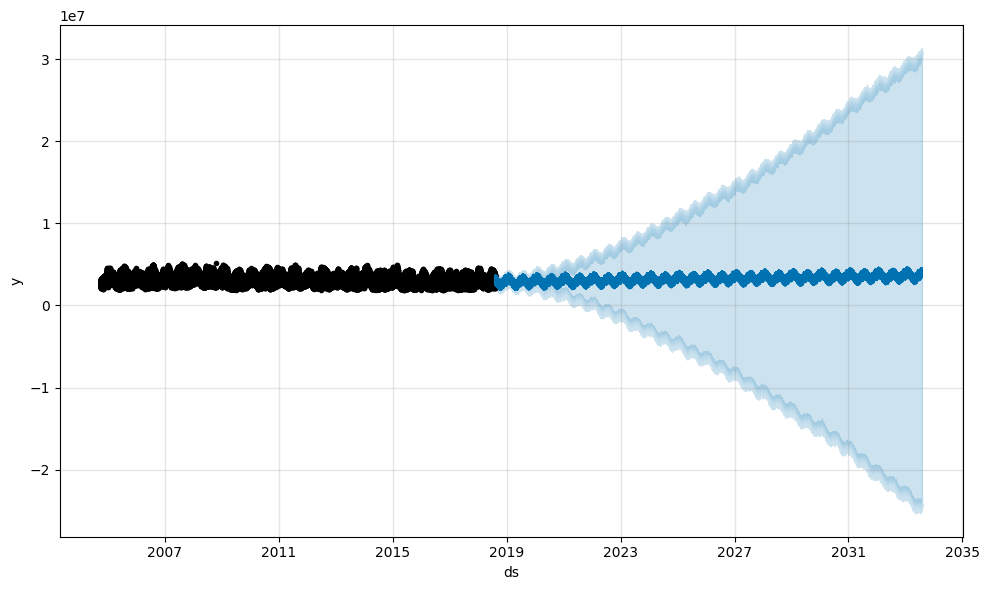

In [18]:
forecast = c_model.predict(future)
fig1 = c_model.plot(forecast)

The plot provides a visual representation of the predicted energy consumption over time, including both historical data and future forecasts. This allows you to understand the expected energy demand and the associated uncertainty, which is crucial for energy planning, resource allocation, and infrastructure development.

The figure generated by this code snippet is a line plot that shows the following:

X-axis: Represents the time, covering both the historical data used for training and the future dates for which forecasts were generated.

Y-axis: Represents the predicted energy consumption (in the units used in the consumption_df DataFrame, likely kW or a scaled version).

Black dots: Represent the actual historical data points used for training the model.

Blue line: Represents the predicted values (forecasts) generated by the Prophet model.

Light blue shaded area: Represents the uncertainty interval (confidence interval) of the forecasts. This indicates the range within which the actual energy consumption is likely to fall.

Interpretation (Similar to Production Forecast Figure):

Consumption trends: The plot shows the overall trend of energy consumption, including any seasonality or cyclical patterns.

Future predictions: It visualizes the predicted energy consumption for the future timeframe defined in the future DataFrame.

Uncertainty: The shaded area indicates the level of uncertainty associated with the forecasts. Wider shaded areas suggest higher uncertainty.

#Optimizing Power Flow: Bridging Solar, SMES, and the City's Grid

We need to use the predictions to determine the optimum battery energy capacity and power flow among the solar installation, the SMES, and the city's power grid.

In [19]:
def LCC(batt_cap):
    return (batt_cap*unit_cap_price)+((coeff_op_main*(batt_cap*unit_cap_price))*calendric_life)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


The LCC function in your code calculates the Levelized Cost of Capacity for a battery energy storage system. It takes into account the battery's capacity, capital cost, operation and maintenance costs, and lifetime. This metric is used for economic evaluation, optimization, and financial analysis of energy storage solutions.

Breaking Down the Formula:

(batt_cap * unit_cap_price): This part calculates the initial capital cost of the battery.

(coeff_op_main * (batt_cap * unit_cap_price)): This calculates the annual operation and maintenance cost, which is assumed to be a fraction (coeff_op_main) of the capital cost.

(... * calendric_life): This multiplies the annual O&M cost by the battery's calendric life to get the total O&M cost over its lifetime.

(... + ...): Finally, the initial capital cost and the total O&M cost are added together to get the total LCC.

In [20]:
optimal_capacity = 0
battery_capacity = optimal_capacity
min_soc = 0.1
max_soc = 0.98
calendric_life = 10 # years
cycle_life = 100000 #cycles
coeff_op_main = 0.03
unit_cap_price=0.169 # $/kWh
cost_batt = battery_capacity*unit_cap_price
cost_op_m = (coeff_op_main*cost_batt)*8760*calendric_life

These variables define the key parameters and assumptions used in the economic analysis and optimization of the energy storage system. They represent the technical characteristics of the battery (capacity, SOC limits, lifetime), its cost (capital cost, O&M costs), and operational constraints. These values will be used in subsequent calculations, particularly for determining the optimal battery capacity that minimizes the Levelized Cost of Capacity (LCC). I hope this explanation is helpful! Let me know if you have any other questions.

Variable Definitions:

optimal_capacity = 0: This line initializes the optimal_capacity variable to 0. This variable will later store the calculated optimal capacity of the battery.

battery_capacity = optimal_capacity: This line sets the initial battery_capacity to the current value of optimal_capacity, which is 0. This is a starting point for the optimization process.

min_soc = 0.1: This line sets the minimum state of charge (SOC) of the battery to 0.1 (or 10%). This represents the lowest allowable charge level for the battery during operation.

max_soc = 0.98: This line sets the maximum state of charge (SOC) of the battery to 0.98 (or 98%). This represents the highest allowable charge level for the battery during operation.

calendric_life = 10: This line sets the calendric life of the battery to 10 years. Calendric life refers to the total lifespan of the battery, regardless of usage.

cycle_life = 100000: This line sets the cycle life of the battery to 100,000 cycles. Cycle life refers to the number of charge-discharge cycles the battery can withstand before its performance degrades significantly.

coeff_op_main = 0.03: This line sets the coefficient for operation and maintenance (O&M) costs to 0.03. This means that the annual O&M cost is assumed to be 3% of the initial capital cost of the battery.

unit_cap_price = 0.169: This line sets the unit capital cost of the battery to $0.169 per kWh. This represents the cost of purchasing and installing the battery per unit of energy storage capacity.

cost_batt = battery_capacity * unit_cap_price: This line calculates the initial capital cost of the battery by multiplying the battery_capacity by the unit_cap_price.

cost_op_m = (coeff_op_main * cost_batt) * 8760 * calendric_life: This line calculates the total operation and maintenance cost of the battery over its lifetime. It multiplies the annual O&M cost (3% of the capital cost) by the number of hours in a year (8760) and the calendric life (10 years).

In [21]:
a,b = int(4e6), int(6e6) #Initial Interval [a,b]
r = (1-math.sqrt(5))/2 # Goldent Ratio
tolerance = 1e-8 # Tolerance for convergence

while abs((b-a)/b)>tolerance:
    a1 = b-r*(b-a)
    a2 = a+r*(b-a)
    if LCC(a1)>LCC(a2):
        a=a1
    else:
        b=a2
optimal_capacity = (a+b)/2
f"Optimal Battery Capacity: {optimal_capacity/1e6} GWh"

'Optimal Battery Capacity: 9.236067850615498 GWh'

This code uses the Golden-section search algorithm to find the battery capacity that minimizes the Levelized Cost of Capacity (LCC) within a specified interval. It iteratively narrows down the search interval until it converges to a solution within the desired tolerance. The calculated optimal capacity is then displayed. This optimization step is crucial for determining the most cost-effective battery size for the energy storage system.

Steps:

Initialization:

a, b = int(4e6), int(6e6): This line sets the initial interval [a, b] for the search. This means the algorithm will search for the optimal capacity between 4,000,000 kWh and 6,000,000 kWh.

r = (1 - math.sqrt(5)) / 2: This line calculates the Golden ratio, which is approximately 0.618. The Golden ratio is used to determine the points within the interval where the function will be evaluated.

tolerance = 1e-8: This line sets the tolerance for convergence. The algorithm will stop when the interval size (b - a) is smaller than this tolerance.

Iteration:

while abs((b - a) / b) > tolerance:: This loop continues as long as the relative interval size is greater than the tolerance.

a1 = b - r * (b - a) and a2 = a + r * (b - a): These lines calculate two new points (a1 and a2) within the interval using the Golden ratio.

if LCC(a1) > LCC(a2):: This condition compares the LCC values at the two new points. If LCC(a1) is greater than LCC(a2), it means the minimum is likely to be in the interval [a1, b], so a is updated to a1.

else: b = a2: Otherwise, the minimum is likely to be in the interval [a, a2], so b is updated to a2.

Result:

optimal_capacity = (a + b) / 2: After the loop converges, the optimal capacity is estimated as the midpoint of the final interval [a, b].

f"Optimal Battery Capacity: {optimal_capacity / 1e6} GWh": This line prints the calculated optimal capacity in GWh.

In [22]:
forecast_df=pd.DataFrame()
forecast_df["Datetime"] = future["ds"][43775:]
forecast_df["P_load"] = forecast["yhat"][43775:]
forecast_df["P_PV"] = production_forecast["yhat_upper"][43775:]
forecast_df=forecast_df.reset_index()
forecast_df

,index,Datetime,P_load,P_PV
0,43775,2023-08-01 00:00:00,3.531889e+06,120943.098796
1,43776,2023-08-01 01:00:00,3.381498e+06,115341.246988
2,43777,2023-08-01 02:00:00,3.267558e+06,122115.759685
3,43778,2023-08-01 03:00:00,3.202068e+06,96737.035160
4,43779,2023-08-01 04:00:00,3.194660e+06,93382.101611
...,...,...,...,...
87644,131419,2033-07-30 20:00:00,4.120116e+06,942132.725431
87645,131420,2033-07-30 21:00:00,4.081582e+06,975315.122555
87646,131421,2033-07-30 22:00:00,3.976807e+06,958124.496784
87647,131422,2033-07-30 23:00:00,3.821163e+06,969649.393225


This code snippet creates a new DataFrame called forecast_df that combines the forecasted energy consumption and solar energy production data for a specific future time period. It selects relevant columns from the future, forecast, and production_forecast DataFrames, resets the index, and displays the DataFrame for inspection. This prepares the data for further analysis, optimization, and decision-making related to the energy storage system.

Steps:

forecast_df = pd.DataFrame(): This line creates an empty Pandas DataFrame named forecast_df. This DataFrame will store the combined forecast data.

forecast_df["Datetime"] = future["ds"][43775:]: This line assigns the values from the 'ds' column of the future DataFrame (starting from index 43775) to a new column named 'Datetime' in the forecast_df DataFrame. This selects the future dates for which forecasts were generated, likely excluding the historical data used for training.

forecast_df["P_load"] = forecast["yhat"][43775:]: This line assigns the predicted energy consumption values (from the 'yhat' column of the forecast DataFrame) to a new column named 'P_load' in the forecast_df DataFrame. This represents the forecasted energy demand.

forecast_df["P_PV"] = production_forecast["yhat_upper"][43775:]: This line assigns the upper bound of the predicted solar energy production values (from the 'yhat_upper' column of the production_forecast DataFrame) to a new column named 'P_PV' in the forecast_df DataFrame. This represents the optimistic forecast for solar energy generation.

forecast_df = forecast_df.reset_index(): This line resets the index of the forecast_df DataFrame. This is often done to create a simple numerical index starting from 0, making it easier to work with the data in subsequent calculations or visualizations.
forecast_df: This line displays the contents of the forecast_df DataFrame, allowing you to inspect the combined forecast data for energy consumption and solar energy production.

#Empowering the Future: Implementing the Vision**

We were successful in orchestrating a seamless integration of the solar installation, the SMES, and the city's power grid. The skyline transformed as advanced solar arrays and the sleek SMES installation emerged, showcasing Solaris City's commitment to a sustainable future.

In [23]:
def calc_power_from_power_plant(params,ind):
    charging_power, discharging_power = params
    power = forecast_df["P_load"][ind]-forecast_df["P_PV"][ind]+charging_power-discharging_power
    if power>0:
        return power[0]
    else:
        return 0

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


The calc_power_from_power_plant function calculates the power that needs to be supplied by the traditional power plant to meet the energy demand, considering solar energy production and the charging/discharging status of the battery. It returns the power required from the power plant if there is an energy deficit, or 0 if there is no deficit or a surplus. This function is crucial for simulating the energy system's operation and evaluating different energy management strategies.

Steps:

def calc_power_from_power_plant(params, ind):: This line defines the function calc_power_from_power_plant, which takes two arguments:

params: A tuple or list containing two values: charging_power and discharging_power. These represent the power being charged into or discharged from the battery, respectively.

ind: An index used to access specific rows in the forecast_df DataFrame, likely representing a particular time step in the simulation.

charging_power, discharging_power = params: This line unpacks the params argument into two separate variables, charging_power and discharging_power.

power = ...: This line calculates the net power needed from the traditional power plant:

forecast_df["P_load"][ind] represents the total energy demand at the given time step.

forecast_df["P_PV"][ind] represents the solar energy production at the given time step.

charging_power represents the power being charged into the battery.

discharging_power represents the power being discharged from the battery.

The formula essentially calculates the difference between the total demand and the available energy from solar and the battery.
if power > 0::

This condition checks if the calculated power is positive. If it is, it means there is a net energy deficit that needs to be supplied by the traditional power plant.

return power[0]: If power is positive, the function returns the value of power[0], which is the first element of the power variable (assuming it is a NumPy array or a Pandas Series).

else: return 0: If power is not positive (meaning there is no energy deficit or there is a surplus), the function returns 0, indicating that the traditional power plant does not need to supply any power.

In [24]:
class PowerOptimizationEnv(gym.Env):
    def __init__(self):
        super(PowerOptimizationEnv, self).__init__()

        # Define simulation parameters
        #self.total_time_steps = len(forecast_df["Datetime"])
        self.battery_capacity = optimal_capacity
        self.current_time = 0
        self.power_plant_power = 0

        self.optimal_power_charge_list = []
        self. optimal_power_discharge_list = []
        self.minimal_power_from_power_plant_list = [sys.maxsize]
        self.battery_capacity_list = []

        # Define observation space (state)
        self.observation_space = spaces.Box(low=0, high=20000000, shape=(3,), dtype=np.float64)

        # Define action space (charge and discharge)
        self.action_space = spaces.Box(low=self.battery_capacity/-3, high=self.battery_capacity/3, shape=(1,), dtype=np.float64)  # Continuous action

        # Other environment-specific parameters
    def calc_reward(self):
        power_reduction =  self.minimal_power_from_power_plant_list[-2]- self.minimal_power_from_power_plant_list[-1]
        if self.battery_capacity<0:
            return sys.maxsize*-1
        else:
            return float(power_reduction+self.battery_capacity)

    def step(self, action):
        # Simulate environment dynamics and calculate reward
        self.battery_capacity+=(action[0]*1e6)
        if action >= 0:
            self.power_plant_power = calc_power_from_power_plant([action*1e6, 0],self.current_time)
            self.optimal_power_charge_list.append(action[0]*1e6)
            self.optimal_power_discharge_list.append(0)
            self.minimal_power_from_power_plant_list.append(self.power_plant_power)
            self.battery_capacity_list.append(self.battery_capacity)

        else:
            self.power_plant_power = calc_power_from_power_plant([0, action], self.current_time)
            self.optimal_power_charge_list.append(0)
            self.optimal_power_discharge_list.append(action[0]*1e6)
            self.minimal_power_from_power_plant_list.append(self.power_plant_power)
            self.battery_capacity_list.append(self.battery_capacity)

         # Update self.current_time and other environment variables
        self.current_time+=1
        # Return next_observation, reward, done, info
        next_observation = np.array([self.battery_capacity, self.current_time, self.power_plant_power], dtype=np.float64)
        reward = self.calc_reward()
        if self.current_time%24 == 0 :
            done = True
        else:
            done = False
        info = {'step': self.current_time}

        if self.current_time>=87647:
            truncated = True
        else:
            truncated = False

        return next_observation, reward,done, truncated, info

    def reset(self,seed=None):
        info = {'step': self.current_time}
        self.current_time = 0

        return np.array([self.battery_capacity, self.current_time, self.power_plant_power], dtype=np.float64).astype(float),info


The PowerOptimizationEnv class creates a reinforcement learning environment for simulating and optimizing the energy system. It defines the state space, action space, reward function, and dynamics of the system. This environment allows an agent to learn an optimal policy for charging and discharging the battery to minimize reliance on the traditional power plant and meet the city's energy demand. I hope this explanation is helpful! Let me know if you have any other questions.

Breakdown:

class PowerOptimizationEnv(gym.Env):: This line defines a class called PowerOptimizationEnv, which inherits from the gym.Env class. This establishes it as a Gymnasium environment, providing a standardized structure for reinforcement learning.

def __init__(self):: This is the constructor of the class, responsible for initializing the environment's attributes:

super().__init__(): Calls the constructor of the parent class (gym.Env).

self.battery_capacity = optimal_capacity: Sets the initial battery capacity to the optimal_capacity calculated earlier.

self.current_time = 0: Initializes the current time step to 0.
self.power_plant_power = 0: Initializes the power supplied by the power plant to 0.

Lists to store simulation data: optimal_power_charge_list, optimal_power_discharge_list, minimal_power_from_power_plant_list, battery_capacity_list.

self.observation_space = ...: Defines the observation space (state space) as a 3-dimensional continuous space with lower bound 0 and upper bound 20,000,000. The state likely represents the battery capacity, current time, and power plant power.

self.action_space = ...: Defines the action space as a 1-dimensional continuous space with bounds determined by the battery capacity. The action likely represents the charging or discharging power of the battery.

def calc_reward(self):: This function calculates the reward for the agent's action. The reward likely encourages minimizing the power drawn from the traditional power plant and maintaining a healthy battery state.

def step(self, action):: This function defines the dynamics of the environment. It takes an action from the agent (charging/discharging power), updates the environment's state (battery capacity, time, power plant power), calculates the reward, and determines if the episode is done (e.g., if a certain time limit is reached).

def reset(self, seed=None):: This function resets the environment to its initial state at the beginning of a new episode.

In [25]:
env = PowerOptimizationEnv()
model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=87600)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 24        |
|    ep_rew_mean     | -6.68e+19 |
| time/              |           |
|    fps             | 1196      |
|    iterations      | 1         |
|    time_elapsed    | 1         |
|    total_timesteps | 2048      |
----------------------------------


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/utils.py:65: RuntimeWarning: invalid value encountered in scalar divide
  return np.nan if var_y == 0 else 1 - np.var(y_true - y_pred) / var_y


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 24        |
|    ep_rew_mean          | -3.87e+18 |
| time/                   |           |
|    fps                  | 920       |
|    iterations           | 2         |
|    time_elapsed         | 4         |
|    total_timesteps      | 4096      |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.42     |
|    explained_variance   | nan       |
|    learning_rate        | 0.0003    |
|    loss                 | inf       |
|    n_updates            | 10        |
|    policy_gradient_loss | 1.83e-09  |
|    std                  | 1         |
|    value_loss           | inf       |
---------------------------------------


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:187: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


--------------------------------------------
| rollout/                |                |
|    ep_len_mean          | 24             |
|    ep_rew_mean          | 6.66e+08       |
| time/                   |                |
|    fps                  | 856            |
|    iterations           | 3              |
|    time_elapsed         | 7              |
|    total_timesteps      | 6144           |
| train/                  |                |
|    approx_kl            | -4.2200554e-09 |
|    clip_fraction        | 0              |
|    clip_range           | 0.2            |
|    entropy_loss         | -1.42          |
|    explained_variance   | nan            |
|    learning_rate        | 0.0003         |
|    loss                 | inf            |
|    n_updates            | 20             |
|    policy_gradient_loss | -4.7e-09       |
|    std                  | 1              |
|    value_loss           | inf            |
--------------------------------------------
----------

This code snippet creates an instance of the energy system environment, initializes a PPO reinforcement learning model, and trains the model within the environment for a specified number of time steps. This process allows the agent to learn the best strategy for charging and discharging the battery to minimize reliance on the traditional power plant and meet the city's energy demand efficiently. I hope this explanation is helpful! Let me know if you have any other questions.

Steps:

env = PowerOptimizationEnv(): This line creates an instance of the PowerOptimizationEnv environment, which we discussed earlier. This environment will be used to train the reinforcement learning agent.

model = PPO("MlpPolicy", env, verbose=1): This line initializes a PPO model using the Stable Baselines3 library.

"MlpPolicy": Specifies the type of policy to use, which is a Multi-Layer Perceptron (MLP) policy. This is a common type of policy used in reinforcement learning.

env: Passes the environment instance (env) to the model, so the agent can interact with it.

verbose=1: Sets the verbosity level to 1, which means the model will print some training information during the learning process.

model.learn(total_timesteps=87600): This line starts the training process for the PPO model.

total_timesteps=87600: Specifies the total number of time steps for training. This means the agent will interact with the environment for 87600 steps (equivalent to 10 years of hourly data) to learn the optimal policy.

In [26]:
test_env = PowerOptimizationEnv()
obs = test_env.reset()[0].astype(float)
for i in range(87649):
    action, _states = model.predict(obs)
    obs, rewards, dones, truncated, info = test_env.step(action)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


This code snippet tests the trained reinforcement learning model in a separate environment, simulating its interaction with the energy system over an extended period. It resets the environment, retrieves initial observations, uses the model to predict actions, applies those actions to the environment, and collects the results (observations, rewards, and other information). This testing process provides valuable insights into the agent's performance and how it manages the battery to minimize reliance on the traditional power plant.

Steps:

test_env = PowerOptimizationEnv(): This line creates a new instance of the PowerOptimizationEnv environment, specifically for testing. This ensures that the testing environment is separate from the training environment and starts in a fresh, initial state.

obs = test_env.reset()[0].astype(float): This line resets the testing environment to its initial state and retrieves the initial observation (obs). The observation is then converted to a float data type, which might be required for compatibility with the model's input format.

for i in range(87649):: This loop iterates over a specified number of time steps (87649, likely representing approximately 10 years of hourly data). This simulates the agent's interaction with the energy system over an extended period.

action, _states = model.predict(obs): Inside the loop, this line uses the trained model (model) to predict the best action (action) based on the current observation (obs). The _states variable is used to store any internal states of the model, but it is not used in this code snippet.

obs, rewards, dones, truncated, info = test_env.step(action): This line takes the predicted action (action) and applies it to the testing environment (test_env). The environment then updates its state, calculates the reward, and provides information about the outcome of the action.

obs: The new observation after taking the action.

rewards: The reward received for the action.

dones: A boolean value indicating whether the episode is done (e.g., if a time limit is reached).

truncated: A boolean value indicating whether the episode was truncated due to reaching maximum steps

info: A dictionary containing additional information about the environment's state.

In [27]:
results_df = pd.DataFrame()
results_df["Charging Power"] = test_env.optimal_power_charge_list
results_df["Discharging Power"] = test_env. optimal_power_discharge_list
results_df["Power Plant Power Output"] = test_env.minimal_power_from_power_plant_list[1:]
results_df["Battery Capacity"] = test_env.battery_capacity_list

This code snippet creates a DataFrame called results_df to store the results of the reinforcement learning agent's actions during testing. It gathers data from the test_env environment, including charging power, discharging power, power plant output, and battery capacity. This organized data is then used for analysis, visualization, and understanding the performance of the trained agent in managing the energy system.

Steps:

results_df = pd.DataFrame(): This line creates an empty Pandas DataFrame named results_df. This DataFrame will store the collected results.

results_df["Charging Power"] = test_env.optimal_power_charge_list: This line assigns the values from the optimal_power_charge_list attribute of the test_env environment to a new column named "Charging Power" in the results_df DataFrame. This column stores the power values when the battery was being charged during the simulation.

results_df["Discharging Power"] = test_env.optimal_power_discharge_list: This line assigns the values from the optimal_power_discharge_list attribute of the test_env environment to a new column named "Discharging Power" in the results_df DataFrame. This column stores the power values when the battery was being discharged during the simulation.

results_df["Power Plant Power Output"] = test_env.minimal_power_from_power_plant_list[1:]: This line assigns the values from the minimal_power_from_power_plant_list attribute of the test_env environment (starting from index 1) to a new column named "Power Plant Power Output" in the results_df DataFrame. This column stores the power output of the traditional power plant during the simulation, likely representing the minimum power needed from the power plant to meet the demand.

results_df["Battery Capacity"] = test_env.battery_capacity_list: This line assigns the values from the battery_capacity_list attribute of the test_env environment to a new column named "Battery Capacity" in the results_df DataFrame. This column stores the battery's capacity level at different time steps during the simulation.

In [28]:
results_df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Charging Power,Discharging Power,Power Plant Power Output,Battery Capacity
0,1.902970e+05,0.000000e+00,3.601243e+06,9.426365e+06
1,8.275465e+04,0.000000e+00,3.348911e+06,9.509120e+06
2,3.176164e+05,0.000000e+00,3.463059e+06,9.826736e+06
3,6.243330e+05,0.000000e+00,3.729664e+06,1.045107e+07
4,0.000000e+00,-1.721256e+06,3.101280e+06,8.729813e+06
...,...,...,...,...
87644,0.000000e+00,-8.300272e+04,3.177983e+06,-9.066336e+05
87645,1.841928e+06,0.000000e+00,4.948195e+06,9.352941e+05
87646,2.257393e+05,0.000000e+00,3.244422e+06,1.161033e+06
87647,1.769938e+06,0.000000e+00,4.621452e+06,2.930972e+06


The line results_df in a Jupyter Notebook or Google Colab environment is used to display the contents of the results_df DataFrame.

In [29]:
percent_change=(results_df["Power Plant Power Output"][87648]-results_df["Power Plant Power Output"][0])/results_df["Power Plant Power Output"][0]
if percent_change<0:
    print(f"Solaris City has experienced a {percent_change*-100:.2f}% decrease in power plant power over 10 years")
elif percent_change>0:
    print(f"Solaris City has experienced a {percent_change*100:.2f}% increase in power plant power over over 10 years")
else:
    print("No change")

Solaris City has experienced a 6.85% increase in power plant power over over 10 years


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


This code snippet calculates the percentage change in power plant power output over a 10-year period based on the results of the reinforcement learning simulation. It then prints a message describing the change, indicating whether there was a decrease, increase, or no change in reliance on the traditional power plant. This is a crucial metric for evaluating the effectiveness of the energy storage system in achieving the project's goals.

#Conclusion

We mananged to successflly integrate SMES with Solar Power with 6.85% increase in power plant power.